# **Book Buddy: Interactive Storytelling using a Gemma-based RAG 📖**

In the realm of AI-driven interactive storytelling, the fusion of Retrieval Augmented Generation (RAG) and Google's Gemma language model opens new avenues for creating engaging narratives and educational experiences. RAG, often likened to an "open-book" approach for AI, empowers models like Gemma to access and synthesize vast amounts of information to answer specific queries or weave intricate tales.

## RAG and Gemma 🤝🏻
[Retrieval-Augmented Generation (RAG)](https://cloud.google.com/use-cases/retrieval-augmented-generation) leverages a dual-model approach: a retriever to fetch relevant information and a generator to craft responses in natural language. This method not only enhances the accuracy of AI-generated content but also reduces computational overhead compared to traditional fine-tuning methods.

[Gemma](https://ai.google.dev/gemma), a lightweight, text-to-text, decoder-only large language model, is known for its precision and efficiency, emerges as an ideal candidate for such tasks, making it a potent tool for interactive storytelling.


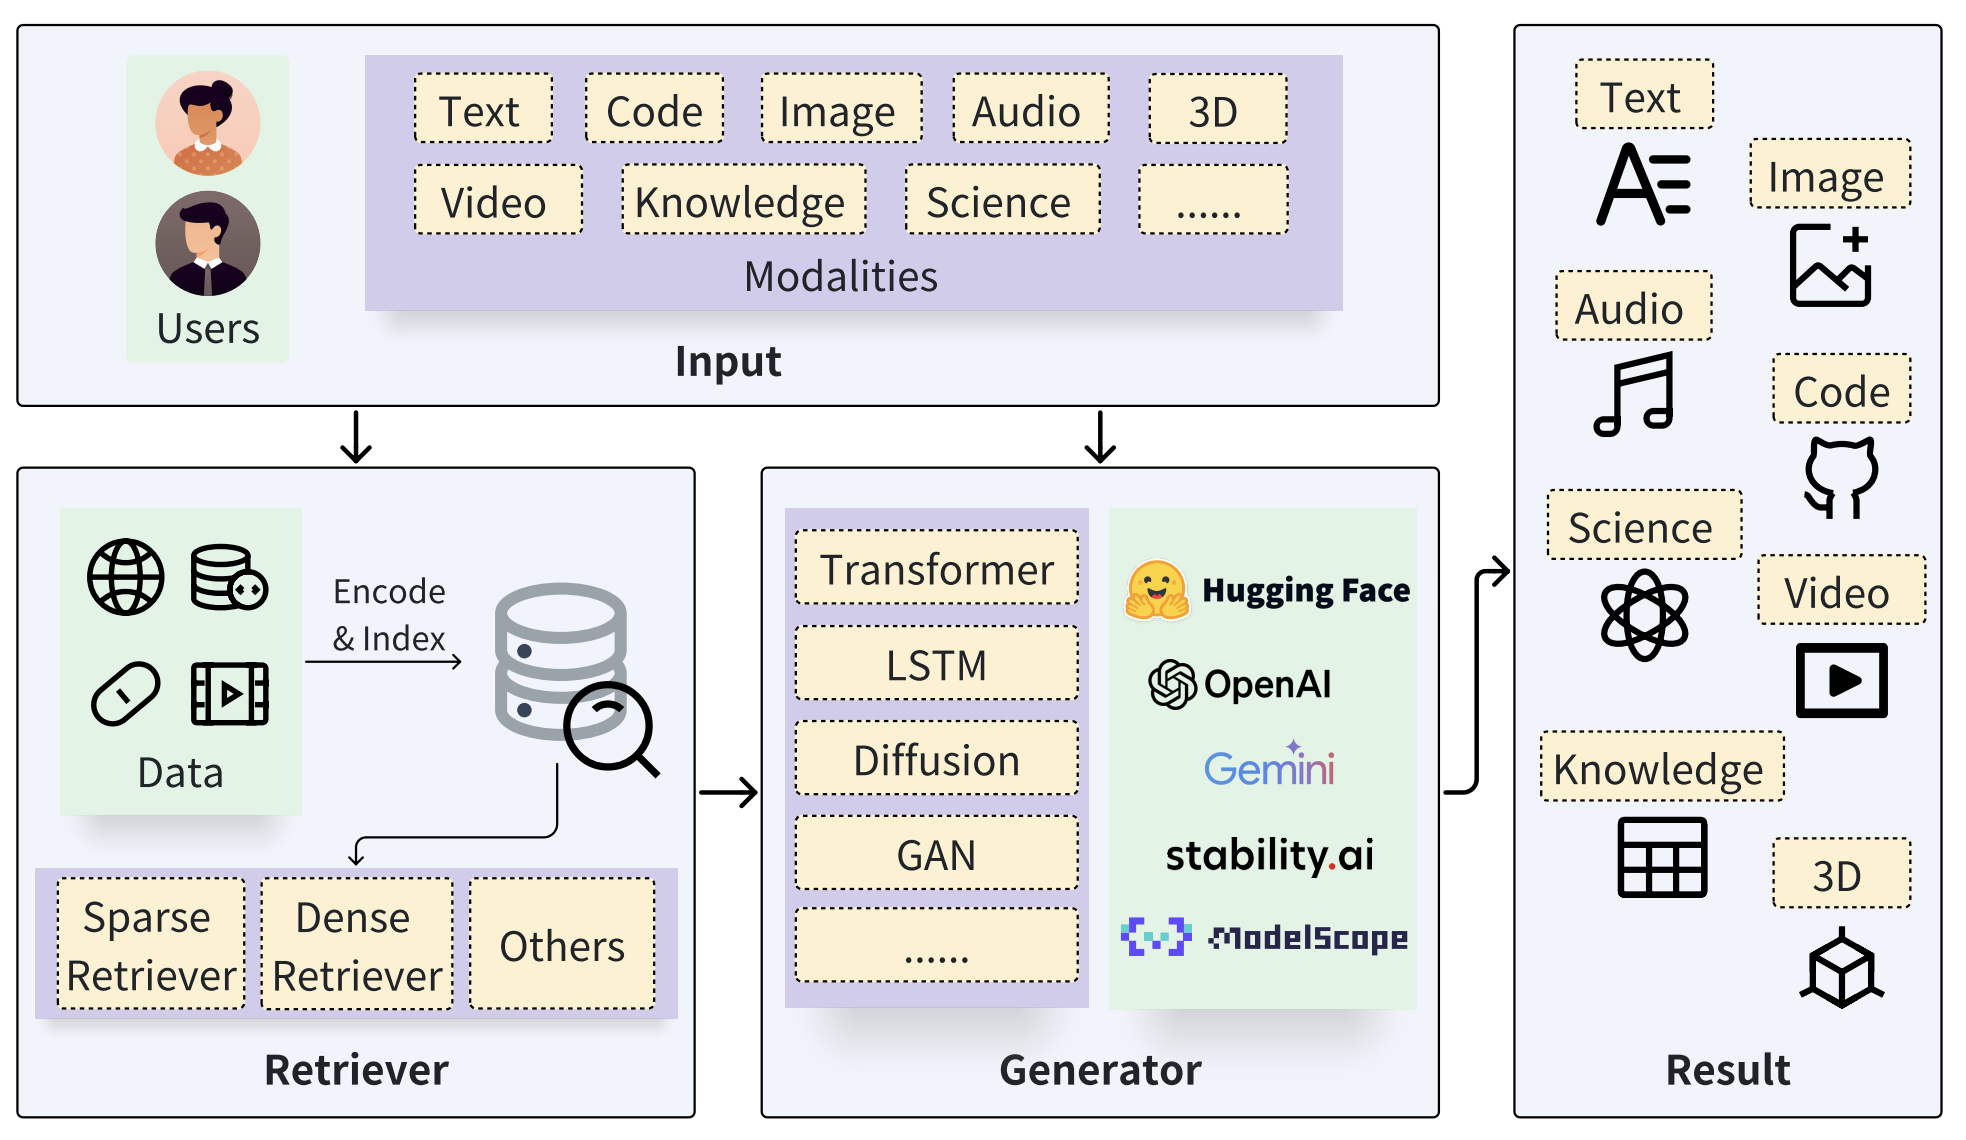

_[A generic RAG architecture, courtesy (arxiv) 'Retrieval-Augmented Generation for AI-Generated Content: A Survey'](https://arxiv.org/pdf/2402.19473)_.


## Crafting Interactive Narratives 🏰
Imagine a scenario where readers can interact with a virtual "Book Buddy," a character powered by Gemma-based RAG. This AI companion can dynamically respond to queries from the storylines and provide detailed explanations on-demand. Whether guiding readers through complex plotlines or explaining background lore, Gemma excels in delivering coherent, engaging content tailored to user interactions.


# **Let's Build "Book Buddy" 🛠️**
To delve deeper into the capabilities of Gemma-based RAG for interactive storytelling, let's embark on a hands-on journey that creates a dynamic system capable of answering questions about the classic text ["Alice's Adventures in Wonderland" by Lewis Carroll](https://www.gutenberg.org/files/11/11-0.txt), available from Project Gutenberg.

By leveraging Gemma's capabilities, we can prototype interactive narratives that respond intelligently to user prompts, offering a personalized storytelling experience. Whether deployed in educational settings to elucidate historical events or within gaming environments to create dynamic quests, the versatility of Gemma-based RAG enriches the user experience through immersive, responsive storytelling.

## **Environment Setup**


In [ ]:
# Installing the packages in an order that minimizes potential dependency
# conflicts and ensures smooth installation.


## Torch and Related Libraries (torch, torchvision, torchaudio).
!pip install -q torch torchvision torchaudio

## Transformers and Related Libraries (transformers, huggingface_hub).
!pip install -q transformers huggingface_hub

## Sentence Transformers: Easy method to compute dense vector representations
## for sentences, paragraphs, and images.
!pip install -q sentence-transformers

## Gradio: Open-source Python package that allows you to quickly build a demo
## or web applications.
!pip install -q gradio

## Accelerate: Abstracts exactly and only the boilerplate code related to
## multi-GPUs/TPU/fp16 and leaves the rest of your code unchanged.
!pip install -q accelerate

## chromadb: The open-source embedding database. The fastest way to build Python
## or JavaScript LLM apps with memory.
!pip install -q chromadb

## Langchain: Framework for developing applications powered by LLMs.
## Langchain Community contains all third party integrations.
!pip install -q langchain langchain_community

## Bits And Bytes: Lightweight Python wrapper around CUDA custom functions.
!pip install -q bitsandbytes

In [ ]:
# Importing the necessary libraries and modules.

## Standard Library Imports.
import os
from typing import Tuple, List

## Third-Party Library Imports.
import gradio as gr

## Google Colab Specific Imports.
from google.colab import userdata

## Local Application/Library Specific Imports.
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader, PyPDFLoader
from langchain_community.vectorstores import Chroma
from langchain.chains import ConversationalRetrievalChain
from langchain_community.embeddings.sentence_transformer import SentenceTransformerEmbeddings
from langchain_community.llms import HuggingFaceEndpoint

In [ ]:
# Setting environment variables for the user agent and Hugging Face Hub API token.
# These ensure that all web requests are identified as originating from the
# "book_buddy/1.0" user agent and authorize the use of Hugging Face's API.

os.environ['USER_AGENT'] = 'book_buddy/1.0'
os.environ['HUGGINGFACEHUB_API_TOKEN'] = userdata.get('HUGGINGFACEHUB_API_TOKEN')

## **Building BookBuddy**

In [ ]:
# Specifying the source document and defining other parameters like chunk_size
# and chunk_overlap for splitting the text into manageable chunks.

# This is the URL for Project Gutenberg's book text for "Alice’s Adventures in
# Wonderland by Lewis Carroll"
BOOK_TEXT_WEB_SOURCE = "https://www.gutenberg.org/files/11/11-0.txt"
TEXT_SPLITTER_CHUNK_SIZE = 1000
TEXT_SPLITTER_CHUNK_OVERLAP = 200

# all-MiniLM-L6-v2: https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2
# It maps sentences & paragraphs to a 384 dimensional dense vector space and can
# be used for tasks like clustering or semantic search.
SENTENCE_TRANSFORMER_EMBEDDINGS_MODEL = "all-MiniLM-L6-v2"

# MMR = Maximal Marginal Relevance (MMR).
# MMR considers the similarity of keywords/keyphrases with the document, along
# with the similarity of already selected keywords and keyphrases.
# This results in a selection that maximizes the diversity wrt the document.
# https://github.com/langchain-ai/langchain/issues/11815
RETREIVER_SEARCH_TYPE = "mmr"
RETREIVER_SEARCH_K = 2

# The language model used for generating responses is Gemma by Google.
GENERATOR_HUGGINGFACEHUB_REPO_ID = "google/gemma-1.1-2b-it"
GENERATOR_MAX_LENGTH = 1024
GENERATOR_TEMPERATURE = 0.1

In [ ]:
class BookBuddy:

    chat_history:  List[Tuple[str, str]] = []
    conversational_retrieval_chain = None

    def __init__(
        self,
        book_text_web_source: str = BOOK_TEXT_WEB_SOURCE,
        text_splitter_chunk_size: int = TEXT_SPLITTER_CHUNK_SIZE,
        text_splitter_chunk_overlap: int = TEXT_SPLITTER_CHUNK_OVERLAP,
        sentence_transformer_embeddings_model: str = SENTENCE_TRANSFORMER_EMBEDDINGS_MODEL,
        retriever_search_type: str = RETREIVER_SEARCH_TYPE,
        retriever_search_k: int = RETREIVER_SEARCH_K,
        generator_huggingfacehub_repo_id: str = GENERATOR_HUGGINGFACEHUB_REPO_ID,
        generator_max_length: int = GENERATOR_MAX_LENGTH,
        generator_temperature: float = GENERATOR_TEMPERATURE,
        is_verbose: bool = True
    ):

      # ------------------------------------------------------------------------
      if is_verbose:
        print("\n\n" + "="*50 + "\nLoading the data...\n" + "="*50)

      # The WebBaseLoader is utilized to load the text from the specified URL.
      book_data_loader = WebBaseLoader(book_text_web_source)
      book_data = book_data_loader.load()

      if is_verbose:
        # Taking a sneak peek at the data...
        print("[test] number of documents: ", len(book_data))
        print("[test] length of first document: ", len(book_data[0].page_content))
        print("[test] book_data[0].page_content[:500]: ", book_data[0].page_content[:500])

      # ------------------------------------------------------------------------

      # The objective is to partition lengthy text documents into smaller, more
      # digestible segments or chunks. This practice enhances efficiency in
      # NLP tasks, addressing constraints that models may encounter with
      # processing extensive amounts of text in a single instance.

      if is_verbose:
        print("\n\n" + "="*50 + "\nSplitting the data...\n" + "="*50)

      # Here we use the RecursiveCharacterTextSplitter to split the document
      # into chunks of text_splitter_chunk_size characters, with an overlap of
      # text_splitter_chunk_overlap characters to maintain context  across chunks.
      recursive_character_text_splitter = RecursiveCharacterTextSplitter(
        chunk_size = text_splitter_chunk_size,
        chunk_overlap = text_splitter_chunk_overlap
      )
      recursive_character_text_splits = recursive_character_text_splitter.split_documents(book_data)
      if is_verbose:
        # Taking a sneak peek at the text splits...
        print("[test] number of chunks: ", len(recursive_character_text_splits))
        print("[test] length of first chunk: ", len(recursive_character_text_splits[0].page_content))
        print("[test] average length of chunks: ",
              sum(len(chunk.page_content) for chunk in recursive_character_text_splits)
              / len(recursive_character_text_splits)
        )
        print("[test] recursive_character_text_splits[0].page_content[:500]: ",
              recursive_character_text_splits[0].page_content[:500])

      # ------------------------------------------------------------------------

      # The next step involves converting textual data into numerical vectors
      # (embeddings) for the text chunks using the sentence_transformer_embeddings_model.

      if is_verbose:
        print("\n\n" + "="*50 + "\nLoading the embeddings model...\n" + "="*50)
      sentence_transformer_embeddings = SentenceTransformerEmbeddings(
          model_name = sentence_transformer_embeddings_model
      )
      if is_verbose:
        # Taking a sneak peek at the sentence transformer embeddings model config...
        print(sentence_transformer_embeddings)

      # ------------------------------------------------------------------------

      # These embeddings are now stored in a specialized / vector database
      # (Chroma) optimized for fast searches and similarity comparisons.

      if is_verbose:
        print("\n\n" + "="*50 + "\nStoring the embeddings in a vector database...\n" + "="*50)
      chroma_vector_db = Chroma.from_documents(
          documents = recursive_character_text_splits,
          embedding = sentence_transformer_embeddings
      )
      if is_verbose:
        # Taking a sneak peek at the sentence transformer embeddings model config...
        print(chroma_vector_db)

      # ------------------------------------------------------------------------

      # Setting up a retrieval mechanism to query the previously created vector
      # database using retriever_search_type and retriever_search_k configuration
      # to ensure diverse and relevant results. The retriever is designed to
      # locate text chunks that exhibit semantic similarity to a specified query.

      if is_verbose:
        print("\n\n" + "="*50 + "\nSetting up the retriever...\n" + "="*50)
      retriever = chroma_vector_db.as_retriever(
          search_type = retriever_search_type,
          search_kwargs={"k": retriever_search_k}
      )
      if is_verbose:
        # Taking a sneak peek at the retriever config...
        print(retriever)

      # ------------------------------------------------------------------------

      # The generator here leverages advanced language modeling techniques to
      # generate human-like answers, enhancing the user experience.

      if is_verbose:
        print("\n\n" + "="*50 + "\nSetting up the generator...\n" + "="*50)
      large_language_model = HuggingFaceEndpoint(
          repo_id = generator_huggingfacehub_repo_id,
          max_length = generator_max_length,
          temperature = generator_temperature
      )
      if is_verbose:
        # Taking a sneak peek at the large language model...
        print("large_language_model: ", large_language_model)

      # ------------------------------------------------------------------------

      # The core of the interactive storytelling application is the
      # ConversationalRetrievalChain, which ties together the language model and
      # the retriever. This chain is designed to locate pertinent information,
      # with the language model, engineered to generate coherent text. Together,
      # they form a unified and robust component. This integration facilitates a
      # seamless and intuitive question-and-answer interaction for users.

      if is_verbose:
        print("\n\n" + "="*50 + "\nSetting up the conversational retrieval chain...\n" + "="*50)

      # In short, this chain allows the system to process user queries, retrieve
      # relevant text chunks, and generate coherent answers.
      self.conversational_retrieval_chain = ConversationalRetrievalChain.from_llm(
          llm = large_language_model,
          retriever = retriever
      )
      if is_verbose:
        # Taking a sneak peek at the conversational retrieval chain config...
        print(self.conversational_retrieval_chain)

      # ------------------------------------------------------------------------

      if is_verbose:
        print("\n\n" + "="*50 + "\nBookBuddy is ready to go!\n" + "="*50)


    def ask_question(
        self,
        question: str,
        chat_history:  List[Tuple[str, str]] = []
    ) -> Tuple[str, List[Tuple[str, str]]]:
        response = self.conversational_retrieval_chain.invoke({
            "question": question,
            "chat_history": chat_history
        })
        chat_history.append((question, response["answer"]))
        # The response contains chat history, question, and the answer.
        return response["answer"], chat_history

## **Testing BookBuddy**


In [ ]:
# Initializing my_book_buddy...
my_book_buddy = BookBuddy()

In [ ]:
test_questions = [
    "Who has written Alice’s Adventures in Wonderland?",
    "What game does Alice play?",
    "Who said - Off with their heads?",
    "Where was the cat from?",
    "What was the last part of the cat to disappear?",
    "What is written on the potion bottle that Alice drinks?",
    "Who fell asleep at the Tea Party?",
    "What is rule 42 and why is it important for Alice?",
    "From what is the Caterpillar in Alice’s Adventures in Wonderland smoking?",
    "Which character serves as herald to the King and Queen of Hearts?"
]

chat_history = []

print("\n\n" + "="*50 + "\nTesting BookBuddy!\n" + "="*50)
for test_question in test_questions:
    answer, chat_history = my_book_buddy.ask_question(test_question, chat_history)
    # print(f"{test_question} → {answer}")
    print("\nQuestion: ", test_question)
    print("Answer: ", answer)
    print("Current Chat History: ", chat_history)

## **Quick Demo**

In [ ]:
def ask_book_buddy(
    book_text_web_source: str = BOOK_TEXT_WEB_SOURCE,
    question: str = "What is the title of the book?",
):
  return BookBuddy(
      book_text_web_source = book_text_web_source,
  ).ask_question(question, [])[0]

with gr.Blocks() as demo:
    header = gr.Markdown(
        """
          # Book Buddy: Interactive Storytelling using a Gemma-based RAG 📖
        """)
    book_text_web_source_textbox = gr.Textbox(
        label = "Book Text Source URL (by default, it uses Project Gutenberg's book text for \"Alice’s Adventures in Wonderland by Lewis Carroll\")")
    question_textbox = gr.Textbox(label="Input your question here")

    input = [book_text_web_source_textbox, question_textbox]

    response_button = gr.Button(value="Answer Please!")

    book_buddy_response = gr.Markdown()
    output = [book_buddy_response]

    response_button.click(ask_book_buddy, input, output)

demo.launch(debug=True)